# Part 2
## Step 1: Image (DenseNet) & Text (Glove) Backbone

In [ ]:
# download image datasets
!pip install --upgrade --no-cache-dir gdown

!gdown "1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download"
!unzip "/content/train_ende.zip"

!gdown "1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download"
!unzip "/content/test.zip"

!gdown "12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download"
!unzip "/content/dev.zip"

In [ ]:
# libraries

import os
import re
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from tqdm.notebook import tqdm
from pickle import dump, load

from pathlib import Path
from PIL import Image
import cv2

import tensorflow as tf
from keras.applications import DenseNet121
from tensorflow.keras import layers, activations, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import load_img, img_to_array, to_categorical

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [ ]:
# make dataset

img_train = Path('/content/train_ende')
img_train = list(img_train.glob(r'**/*.jpg'))
img_train = pd.Series(img_train).astype(str)
img_train = pd.Series(sorted(img_train, key=lambda x:int(re.findall('(\d+)', x)[0])), name='images')
txt_train = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_train.txt', names=['sentences'], header=None)
lbl_train = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_train.txt',names=['labels'], header=None)
train_set = pd.concat([img_train, txt_train, lbl_train], axis=1)

img_val = Path('/content/dev')
img_val = list(img_val.glob(r'**/*.jpg'))
img_val = pd.Series(img_val).astype(str)
img_val = pd.Series(sorted(img_val, key=lambda x:int(re.findall('(\d+)', x)[0])), name='images')
txt_val = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_dev.txt', names=['sentences'], header=None)
lbl_val = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_dev.txt',names=['labels'], header=None)
val_set = pd.concat([img_val, txt_val, lbl_val], axis=1)

img_test = Path('/content/test')
img_test = list(img_test.glob(r'**/*.jpg'))
img_test = pd.Series(img_test).astype(str)
img_test = pd.Series(sorted(img_test, key=lambda x:int(re.findall('(\d+)', x)[0])), name='images')
txt_test = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_test.txt', names=['sentences'], header=None)
lbl_test = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_test.txt',names=['labels'], header=None)
test_set = pd.concat([img_test, txt_test, lbl_test], axis=1)

## Image Model

In [ ]:
def resize(img):
  img = plt.imread(img)
  resized_image = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
  resized_image = np.expand_dims(resized_image, axis=0)
  return resized_image

In [ ]:
resized_train_images = np.array([resize(img) for img in train_set['images']]).reshape(len(train_set['images']), 128, 128, 3)
resized_val_images = np.array([resize(img) for img in val_set['images']]).reshape(len(val_set['images']), 128, 128, 3)
resized_test_images = np.array([resize(img) for img in test_set['images']]).reshape(len(test_set['images']), 128, 128, 3)

train_labels = train_set.labels.values
val_labels = val_set.labels.values
test_labels = test_set.labels.values

In [ ]:
def DenseNet(summary=False):

  dense_layer = DenseNet121(weights='imagenet', input_shape=(128,128,3), include_top=False)
  dense_layer.trainable = False

  inputs = layers.Input(shape=(128,128,3))
  x = dense_layer(inputs, training=False)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  prediction = layers.Dense(3, activation='softmax')(x)

  model = models.Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
image_model = DenseNet()
image_model.fit(resized_train_images, train_labels, epochs=15, batch_size=128, validation_data=(resized_val_images, val_labels))

Epoch 1/15
159/159 [==============================] - 33s 157ms/step - loss: 1.7812 - accuracy: 0.3385 - val_loss: 1.4176 - val_accuracy: 0.3462
Epoch 2/15
159/159 [==============================] - 23s 143ms/step - loss: 1.5612 - accuracy: 0.3671 - val_loss: 1.2208 - val_accuracy: 0.3569
Epoch 3/15
159/159 [==============================] - 24s 150ms/step - loss: 1.4706 - accuracy: 0.3800 - val_loss: 1.1846 - val_accuracy: 0.3703
Epoch 4/15
159/159 [==============================] - 24s 150ms/step - loss: 1.4037 - accuracy: 0.3856 - val_loss: 1.1780 - val_accuracy: 0.3733
Epoch 5/15
159/159 [==============================] - 23s 147ms/step - loss: 1.3405 - accuracy: 0.3981 - val_loss: 1.1780 - val_accuracy: 0.3686
Epoch 6/15
159/159 [==============================] - 23s 148ms/step - loss: 1.3098 - accuracy: 0.4016 - val_loss: 1.1639 - val_accuracy: 0.3658
Epoch 7/15
159/159 [==============================] - 23s 147ms/step - loss: 1.2646 - accuracy: 0.4126 - val_loss: 1.1768 - val_ac

In [ ]:
# initial prediction of image_model (to be compared with tuned model)

initial_pred = image_model.predict(resized_test_images)
initial_pred = np.argmax(initial_pred, axis=1)
print('Accuracy: ', accuracy_score(test_labels, initial_pred))
print('f1_score: ', f1_score(test_labels, initial_pred, average='weighted'))

159/159 [==============================] - 7s 35ms/step
Accuracy:  0.37793566212749163
f1_score:  0.3324419324133743


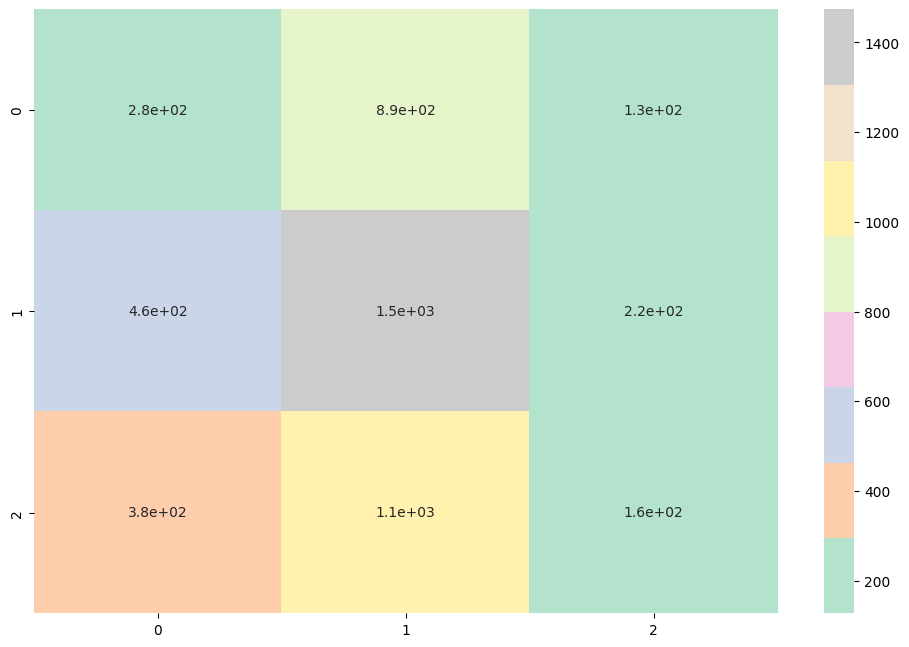

In [ ]:
cm = confusion_matrix(test_labels, initial_pred)
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(cm, annot=True, cmap='Pastel2')
plt.show()

## Text Model

In [ ]:
def clean_text(sentence):
  sentence = str(sentence).lower()
  sentence = re.sub('[^a-z]',' ',sentence)
  sentence = word_tokenize(sentence)
  stop_words = stopwords.words('english')
  sentence = [i for i in sentence if i not in stop_words]
  sentence = [i for i in sentence if len(i)>1]
  sentence = ' '.join(sentence)
  return sentence

In [ ]:
train_set['sentences'] = train_set['sentences'].apply(clean_text)
val_set['sentences'] = val_set['sentences'].apply(clean_text)
test_set['sentences'] = test_set['sentences'].apply(clean_text)

train_sentences = train_set.sentences.values
val_sentences = val_set.sentences.values
test_sentences = test_set.sentences.values

In [ ]:
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

f = open('/tmp/glove/glove.6B.50d.txt')

glove_vecs = {}

for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype="float32")
    glove_vecs[word] = vec
f.close()

--2023-02-09 19:05:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-09 19:05:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-09 19:05:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
all_centences = np.append(train_sentences,val_sentences)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_centences)
word2idx = tokenizer.word_index

glove_embedding_matrix = np.zeros((len(word2idx) + 1, 50))
for word, i in word2idx.items():
  if i < len(word2idx):
    embedding_vector = glove_vecs.get(word)
    if embedding_vector is not None:
      glove_embedding_matrix[i] = embedding_vector

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=10)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=10)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=10)

In [ ]:
def model():
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=glove_embedding_matrix.shape[0],
                                    output_dim=glove_embedding_matrix.shape[1],
                                    input_length=10,
                                    weights=[glove_embedding_matrix],
                                    trainable=False))
  model.add(layers.Bidirectional(layers.LSTM(100, recurrent_dropout=0.1, return_sequences=True)))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dense(50))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
text_model = model()
text_model.fit(train_padded, train_labels, epochs=10, batch_size=128, validation_data=(val_padded, val_labels))

Epoch 1/10
159/159 [==============================] - 19s 98ms/step - loss: 1.0302 - accuracy: 0.4757 - val_loss: 1.0150 - val_accuracy: 0.4890
Epoch 2/10
159/159 [==============================] - 18s 112ms/step - loss: 0.9942 - accuracy: 0.5081 - val_loss: 0.9994 - val_accuracy: 0.4993
Epoch 3/10
159/159 [==============================] - 16s 101ms/step - loss: 0.9804 - accuracy: 0.5179 - val_loss: 0.9972 - val_accuracy: 0.5021
Epoch 4/10
159/159 [==============================] - 15s 93ms/step - loss: 0.9735 - accuracy: 0.5274 - val_loss: 0.9980 - val_accuracy: 0.4993
Epoch 5/10
159/159 [==============================] - 15s 94ms/step - loss: 0.9608 - accuracy: 0.5374 - val_loss: 0.9866 - val_accuracy: 0.5082
Epoch 6/10
159/159 [==============================] - 16s 100ms/step - loss: 0.9534 - accuracy: 0.5404 - val_loss: 0.9910 - val_accuracy: 0.5042
Epoch 7/10
159/159 [==============================] - 15s 93ms/step - loss: 0.9435 - accuracy: 0.5466 - val_loss: 0.9848 - val_accura

## Step 2 

In [ ]:
# tain on new dataset (unlabeld for us) --> fliker8k

!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

In [ ]:
image_dir = Path('/content/all_images/Flicker8k_Dataset')
image_paths = list(image_dir.glob(r'**/*.jpg'))
image_str_paths = pd.Series(image_paths, name='ImagePath').astype(str)
image_names = pd.Series([i.split("/")[-1] for i in image_str_paths], name='ImageName')
df = pd.concat([image_str_paths,image_names], axis=1)

In [ ]:
texts_file = open('/content/all_captions/Flickr8k.token.txt', 'r')
texts_file = texts_file.read()
texts_file = texts_file.split('\n')
texts_file = texts_file[:-1]
texts_dict = {}

for des in texts_file:
  if des.split('\t')[0][:-2] not in texts_dict:
    texts_dict[des.split('\t')[0][:-2]] = [des.split('\t')[1]]
texts_df = pd.DataFrame({'ImageName':list(texts_dict.keys()),
                         'ImageDescription':list(texts_dict.values())})

In [ ]:
df = df.merge(texts_df, on='ImageName')
df.head(5)

,ImagePath,ImageName,ImageDescription
0,/content/all_images/Flicker8k_Dataset/20793096...,207930963_af3a2f1784.jpg,[A group of people in protective gear .]
1,/content/all_images/Flicker8k_Dataset/32160857...,3216085740_699c2ce1ae.jpg,[A crowd holds American flags .]
2,/content/all_images/Flicker8k_Dataset/23379198...,2337919839_df83827fa0.jpg,[A little boy kicks a soccer ball in the park .]
3,/content/all_images/Flicker8k_Dataset/29229732...,2922973230_5a769ef92a.jpg,[A female walking through grass .]
4,/content/all_images/Flicker8k_Dataset/36321979...,3632197966_0c5061025f.jpg,[a dirt biker clears a jump .]


In [ ]:
df_images = np.array([resize(img) for img in df['ImagePath']]).reshape(len(df['ImagePath']), 128, 128, 3)
df['ImageDescription'] = df['ImageDescription'].apply(clean_text)
df_sentences = df['ImageDescription'].values

df_sequences = tokenizer.texts_to_sequences(df_sentences)
df_sentences_padded = pad_sequences(df_sequences, maxlen=10)

In [ ]:
text_pred_unlabels = text_model.predict(df_sentences_padded)

253/253 [==============================] - 2s 8ms/step


In [ ]:
def DenseNet(summary=False):

  dense_layer = DenseNet121(weights='imagenet', input_shape=(128,128,3), include_top=False)
  dense_layer.trainable = False

  inputs = layers.Input(shape=(128,128,3))
  x = dense_layer(inputs, training=False)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  prediction = layers.Dense(3, activation='linear')(x)

  model = models.Model(inputs=inputs, outputs=prediction)

  if summary:
    print(model.summary())

  return model

In [ ]:
# tune image_model on unlabeled dataset and not perfect text labels

image_model = DenseNet()
image_model.compile(optimizer='adam',loss='mean_squared_error')
image_model.fit(df_images, text_pred_unlabels, epochs=15, batch_size=128, validation_split=0.2)

Epoch 1/15
51/51 [==============================] - 17s 197ms/step - loss: 2.3560 - val_loss: 1.1028
Epoch 2/15
51/51 [==============================] - 8s 165ms/step - loss: 1.2013 - val_loss: 0.6454
Epoch 3/15
51/51 [==============================] - 7s 145ms/step - loss: 0.7002 - val_loss: 0.1493
Epoch 4/15
51/51 [==============================] - 7s 146ms/step - loss: 0.4302 - val_loss: 0.0811
Epoch 5/15
51/51 [==============================] - 7s 145ms/step - loss: 0.2762 - val_loss: 0.0404
Epoch 6/15
51/51 [==============================] - 8s 148ms/step - loss: 0.1679 - val_loss: 0.0330
Epoch 7/15
51/51 [==============================] - 8s 151ms/step - loss: 0.1106 - val_loss: 0.0300
Epoch 8/15
51/51 [==============================] - 8s 154ms/step - loss: 0.0772 - val_loss: 0.0284
Epoch 9/15
51/51 [==============================] - 8s 151ms/step - loss: 0.0555 - val_loss: 0.0283
Epoch 10/15
51/51 [==============================] - 7s 146ms/step - loss: 0.0447 - val_loss: 0.026

In [ ]:
# final prediction of image_model (to be compared with initial model)

final_pred = image_model.predict(resized_test_images)
final_pred = np.argmax(final_pred, axis=1)
print('Accuracy: ', accuracy_score(test_labels, final_pred))
print('f1_score: ', f1_score(test_labels, final_pred, average='weighted'))

159/159 [==============================] - 7s 34ms/step
Accuracy:  0.2843891849220446
f1_score:  0.2011869306231606


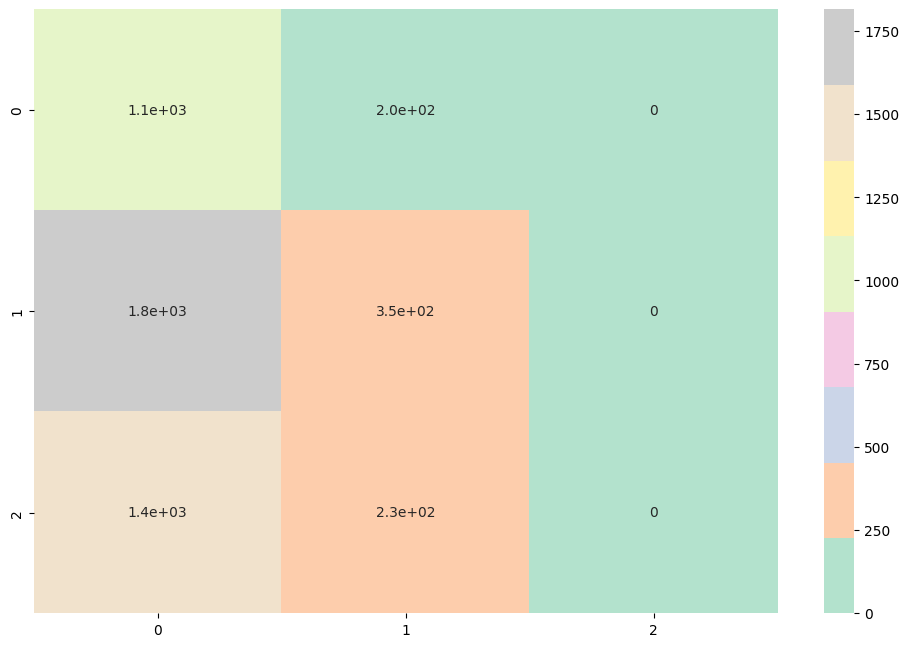

In [ ]:
cm = confusion_matrix(test_labels, final_pred)
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(cm, annot=True, cmap='Pastel2')
plt.show()